**Our aim is to analyze housing price by using PySpark**

***Steps:***

- Cleaning the data
- Exploratory data analysis
- Feature Engineering
- Corrleation analysis
- Linear Regression
- Random Forest Regressor

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/california_housing_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [81]:
#Installing PySpark
!pip install pyspark

In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [83]:
# Initializing Spark Session
spark  = SparkSession.builder.appName('Dataframe').getOrCreate()

In [84]:
# Reading the dataset
df_housing = spark.read.option('header', 'true').csv('/content/dataset/housing.csv', inferSchema = True)

In [85]:
# Showing first 5 rows
df_housing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [86]:
# Checking the schema
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [87]:
# Summary statistics
df_housing.select(['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms']).describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|
+-------+-------------------+-----------------+------------------+------------------+------------------+
|  count|              20640|            20640|             20640|             20640|             20433|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|
| stddev|  2.003531723502584|2.135952397457101| 12.58555761211163|2181.6152515827944|421.38507007403115|
|    min|            -124.35|            32.54|               1.0|               2.0|               1.0|
|    max|            -114.31|            41.95|              52.0|           39320.0|            6445.0|
+-------+-------------------+-----------------+------------------+------------------+------------------+



In [88]:
df_housing.select(['population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']).describe().show()
 #  Look at the minimum and maximum values of all the (numerical) attributes. We see that multiple attributes have a wide range of values: we will need to normalize the dataset.

+-------+------------------+-----------------+------------------+------------------+---------------+
|summary|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+------------------+-----------------+------------------+------------------+---------------+
|  count|             20640|            20640|             20640|             20640|          20640|
|   mean|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  1132.46212176534|382.3297528316098| 1.899821717945263|115395.61587441359|           NULL|
|    min|               3.0|              1.0|            0.4999|           14999.0|      <1H OCEAN|
|    max|           35682.0|           6082.0|           15.0001|          500001.0|     NEAR OCEAN|
+-------+------------------+-----------------+------------------+------------------+---------------+



In [89]:
# Checking first 10 value for specific column
df_housing.select(['median_house_value']).show(10)

+------------------+
|median_house_value|
+------------------+
|          452600.0|
|          358500.0|
|          352100.0|
|          341300.0|
|          342200.0|
|          269700.0|
|          299200.0|
|          241400.0|
|          226700.0|
|          261100.0|
+------------------+
only showing top 10 rows



In [90]:
# Checking if any missing value is present or not
for column in df_housing.columns:
    print(column, df_housing.filter(col(column).cast("float").isin([None,np.nan])).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [91]:
# Renaming median_house_value as price
df_housing = df_housing.withColumnRenamed('median_house_value','price')

In [92]:
#Droping if NaN or Null
df_housing.na.drop()

DataFrame[longitude: double, latitude: double, housing_median_age: double, total_rooms: double, total_bedrooms: double, population: double, households: double, median_income: double, price: double, ocean_proximity: string]

In [93]:
type(df_housing['price'])

pyspark.sql.column.Column

**Perliminary analysis**

<ipython-input-94-bbb47950d474>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_housing.select('price').toPandas(), color="skyblue")


+------------------+------------------+
|   skewness(price)|   kurtosis(price)|
+------------------+------------------+
|0.9776922140978437|0.3275001388119674|
+------------------+------------------+



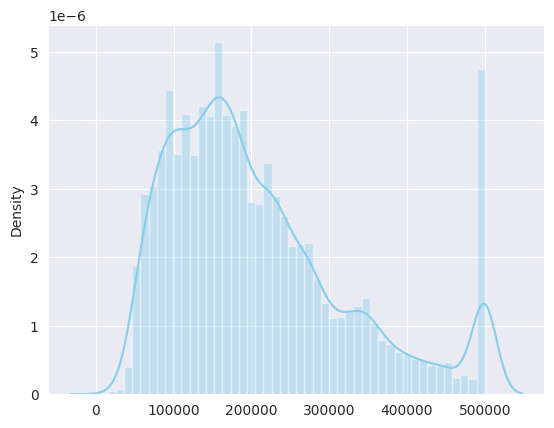

In [94]:
# Checking if the prices are normally distributed
sns.distplot(df_housing.select('price').toPandas(), color="skyblue")
df_housing.select(F.skewness('price'), F.kurtosis('price')).show()

In [95]:
# Housing prices greater than 500,000 (expensive houses)
print("No of houses: %i" % df_housing.select('price').count())
print("No of houses greater than $500000 are: %i" % df_housing.filter(df_housing["price"] > 500000).count())

No of houses: 20640
No of houses greater than $500000 are: 965


<Axes: ylabel='Count'>

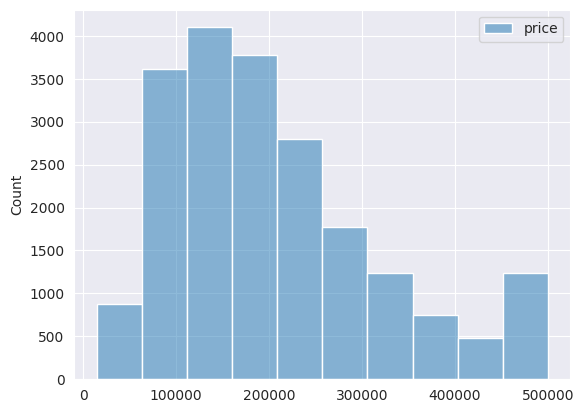

In [96]:
# Price Distribution
sns.set_style("darkgrid")
sns.histplot(df_housing.select('price').toPandas(), bins = 10)

<Axes: xlabel='total_rooms', ylabel='avg(price)'>

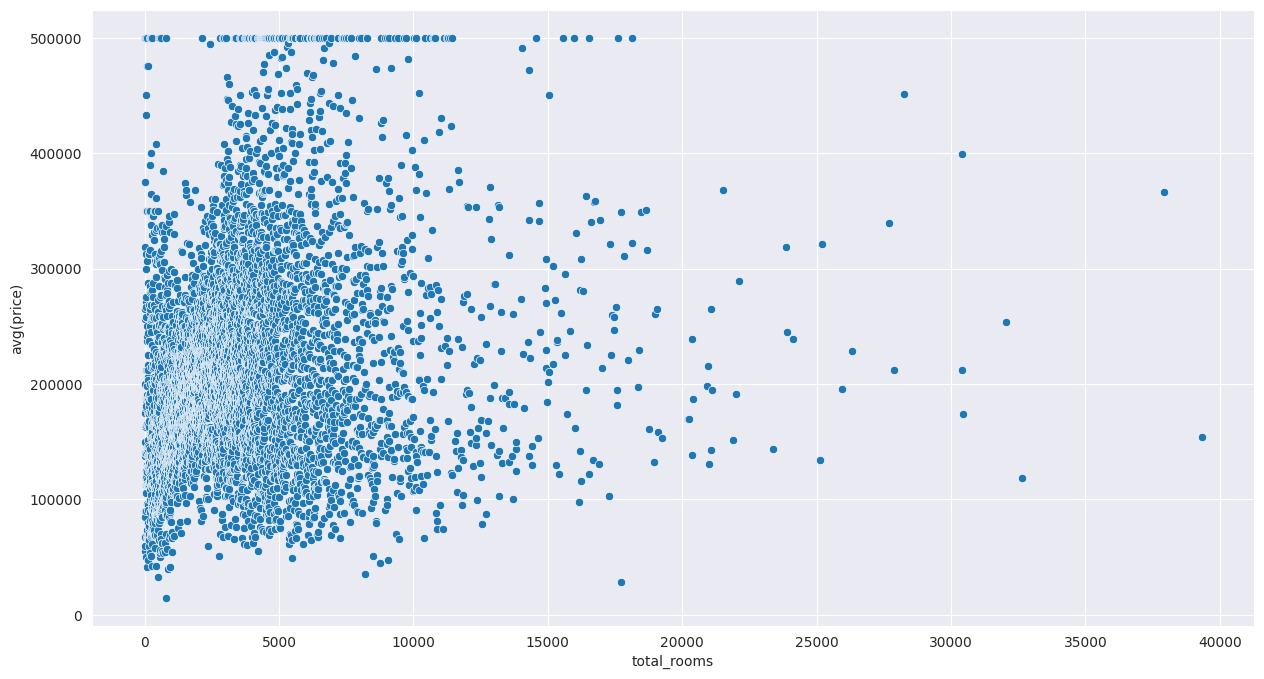

In [97]:
# Average price of house
df1 = df_housing.groupby('total_rooms').avg().sort('total_rooms').select(['total_rooms','avg(price)'])
df_p = df1.toPandas()
plt.figure(figsize = (15, 8))
sns.scatterplot(x = df_p['total_rooms'], y = df_p['avg(price)'] )

In [98]:
df_housing.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'price',
 'ocean_proximity']

#Feature Engineering


*   Rooms per household which refers to the number of rooms in households per block group;
*   Population per household, which basically gives us an indication of how many people live in households per block group;
*   per_capita_income which will give us an idea about the per capita income of people in the area;

In [99]:
# Creating a new feature of per-capita income and adding it to the dataframe
df_housing = df_housing.withColumn('per_capita_income', df_housing['median_income']*10000/df_housing['population'])
df_housing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   price|ocean_proximity| per_capita_income|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+------------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|452600.0|       NEAR BAY|258.54658385093165|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|358500.0|       NEAR BAY| 34.57476051645147|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|352100.0|       NEAR BAY|146.31854838709677|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|341300.0|       

In [100]:
# Feature Engineering
df_housing = (df_housing.withColumn("rooms_per_hosuehold", F.round(col("total_rooms")/col("households"), 2))
                       .withColumn("poppulation_per_household", F.round(col("population")/col("households"), 2)))

In [101]:
df_housing.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+------------------+--------+--------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|   price|ocean_proximity| per_capita_income|rmsperhh|popperhh|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+--------+---------------+------------------+--------+--------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|452600.0|       NEAR BAY|258.54658385093165|    6.98|    2.56|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|358500.0|       NEAR BAY| 34.57476051645147|    6.24|    2.11|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|352100.0|       NEAR BAY|146.31854838709677|    8.29|     2.8|
|  -122.25

[(0.0, 500.0)]

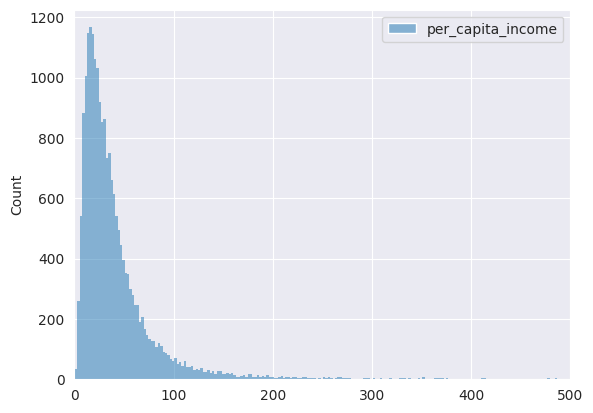

In [102]:
# per_capita_income distribution
g = sns.histplot(df_housing.select('per_capita_income').toPandas())
g.set(xlim = (0, 500))

<Axes: xlabel='per_capita_income', ylabel='price'>

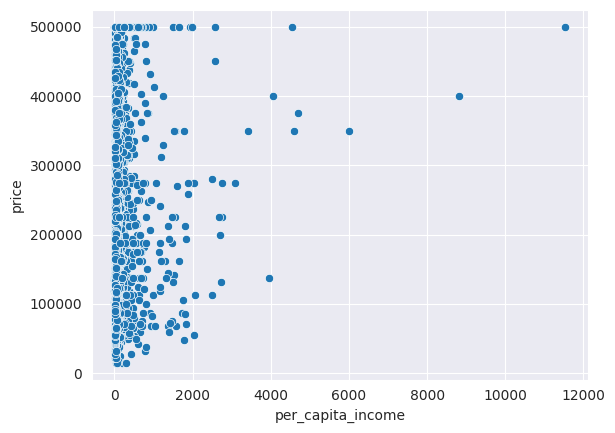

In [103]:
# Per-capita-income and prices of the home
df_p = df_housing.toPandas()
sns.scatterplot(x = df_p['per_capita_income'], y = df_p['price'])

In [104]:
# Counting per capita that are less than $100
count_blocks = df_housing.filter('per_capita_income <  100').count()/df_housing.select('per_capita_income').count()*100
print("Percentage of blocks below $100 per capita: %2f" % count_blocks)

Percentage of blocks below $100 per capita: 92.596899


In [105]:
# Checking unique values in ocean_proximity
df_housing.select('ocean_proximity').distinct().show()

+---------------+
|ocean_proximity|
+---------------+
|         ISLAND|
|     NEAR OCEAN|
|       NEAR BAY|
|      <1H OCEAN|
|         INLAND|
+---------------+



<Axes: xlabel='ocean_proximity', ylabel='avg(median_income)'>

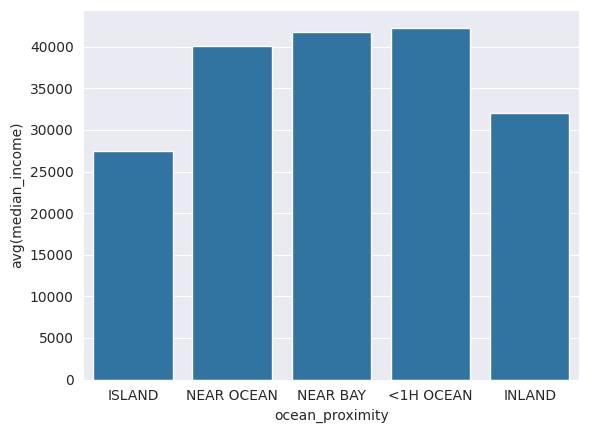

In [106]:
# Where does wealthy people live?
df_i = df_housing.groupby('ocean_proximity').agg({'median_income' : 'avg'})
df_p = df_i.toPandas()
sns.barplot(x = df_p['ocean_proximity'], y = df_p['avg(median_income)']*10000)

# Houses that are less than 1 hour to ocean where most wealthy people wants to live

In [107]:
# Label-encoding for the "ocean_proximity" column
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_index")
df_housing = indexer.fit(df_housing).transform(df_housing)
df_housing = df_housing.drop('ocean_proximity')
df_housing.select('ocean_proximity_index').show(3)

+---------------------+
|ocean_proximity_index|
+---------------------+
|                  3.0|
|                  3.0|
|                  3.0|
+---------------------+
only showing top 3 rows



In [108]:
# Removing na values to ensure correlation method works properly
mean = df_housing.select(F.mean('total_bedrooms')).collect()[0][0]
df_housing = df_housing.na.fill({'total_bedrooms': mean})

In [109]:
# Checking if na values exist in 'total_bedrooms' columns
df_housing.filter(col('total_bedrooms').isNull()).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-----------------+--------+--------+---------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|price|per_capita_income|rmsperhh|popperhh|ocean_proximity_index|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-----------------+--------+--------+---------------------+
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+-----+-----------------+--------+--------+---------------------+



<Axes: >

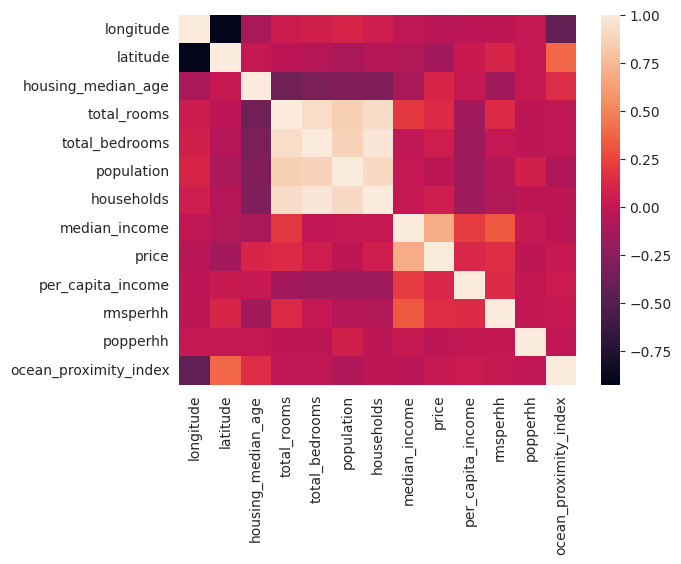

In [110]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
assembler = VectorAssembler(inputCols=df_housing.columns, outputCol="features")
df_vector = assembler.transform(df_housing).select("features")

# get correlation matrix
matrix = Correlation.corr(df_vector, 'features')
corrmatrix = matrix.collect()[0][0].toArray().tolist()

# Convert to pandas dataframe
df_corr = pd.DataFrame(corrmatrix, columns = df_housing.columns, index = df_housing.columns)

# plot correlation matrix by using seaborn
sns.heatmap(df_corr)

In [111]:
df_housing.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'price',
 'per_capita_income',
 'rmsperhh',
 'popperhh',
 'ocean_proximity_index']

In [112]:
# First, let's start with the medianHouseValue, our dependent variable. To facilitate our working with the target values, we will express the house values in units of 100,000.
# That means that a target such as 452600.000000 should become 4.526:
df_housing = df_housing.withColumn("price", col("price")/100000)

In [113]:
# Drop non-correlated columns
df_model = df_housing.select("price",
                              "total_bedrooms",
                              "population",
                              "households",
                              "median_income",
                              "rooms_per_hosuehold",
                              "poppulation_per_household",
                              )
df_model.show(3)

+-----+--------------+----------+----------+-------------+--------+--------+
|price|total_bedrooms|population|households|median_income|rmsperhh|popperhh|
+-----+--------------+----------+----------+-------------+--------+--------+
|4.526|         129.0|     322.0|     126.0|       8.3252|    6.98|    2.56|
|3.585|        1106.0|    2401.0|    1138.0|       8.3014|    6.24|    2.11|
|3.521|         190.0|     496.0|     177.0|       7.2574|    8.29|     2.8|
+-----+--------------+----------+----------+-------------+--------+--------+
only showing top 3 rows



<ipython-input-114-08c4f5489ff9>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_housing.select('housing_median_age').toPandas(), color="skyblue")


+----------------------------+----------------------------+
|skewness(housing_median_age)|kurtosis(housing_median_age)|
+----------------------------+----------------------------+
|        0.060326253016608676|         -0.8007255995445028|
+----------------------------+----------------------------+



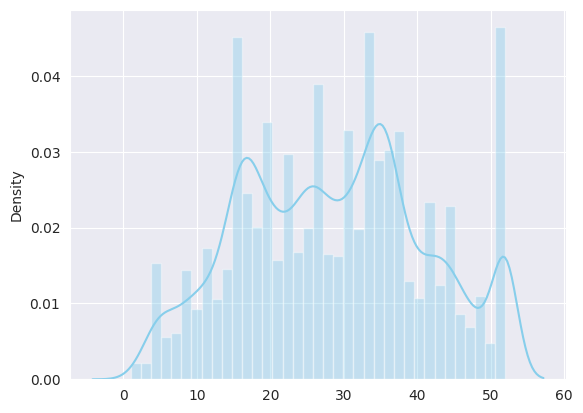

In [114]:
# Checking normal distribution of selected fetures
# housing_median_age

sns.distplot(df_housing.select('housing_median_age').toPandas(), color="skyblue")
df_housing.select(F.skewness('housing_median_age'), F.kurtosis('housing_median_age')).show()

# housing_median_age is normally distributed

<ipython-input-115-c731652d61e4>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_housing.select('total_rooms').toPandas(), color="skyblue")


+---------------------+---------------------+
|skewness(total_rooms)|kurtosis(total_rooms)|
+---------------------+---------------------+
|    4.147042038773302|    32.62273207294906|
+---------------------+---------------------+



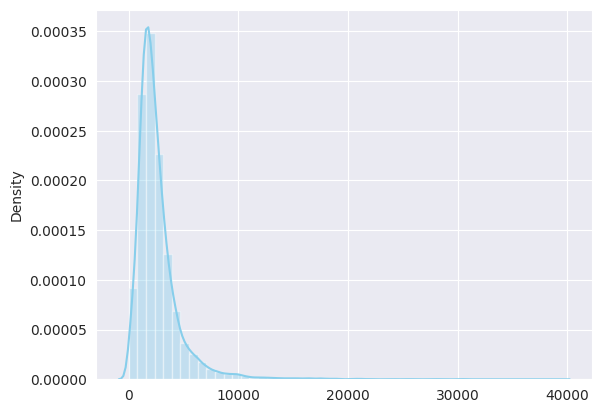

In [115]:
# Checking normal distribution of selected fetures
# total_rooms

sns.distplot(df_housing.select('total_rooms').toPandas(), color="skyblue")
df_housing.select(F.skewness('total_rooms'), F.kurtosis('total_rooms')).show()

# the total_rooms is not normally distributed
# Using lograthimic scale to normalize the data

<ipython-input-116-de8436a5a77c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_model.select('total_rooms_log').toPandas(), color="skyblue")


+-------------------------+-------------------------+
|skewness(total_rooms_log)|kurtosis(total_rooms_log)|
+-------------------------+-------------------------+
|      -1.0805050813078412|        5.178808742167776|
+-------------------------+-------------------------+



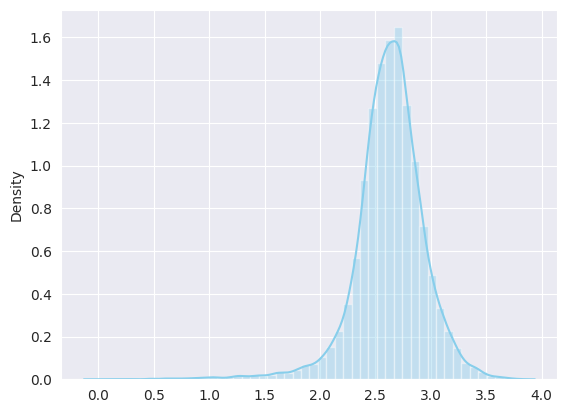

In [116]:
df_model = df_model.withColumn("total_rooms_log", F.log10(col("total_bedrooms")))

sns.distplot(df_model.select('total_rooms_log').toPandas(), color="skyblue")
df_model.select(F.skewness('total_rooms_log'), F.kurtosis('total_rooms_log')).show()

# The distribution is now lograthmic distributed

<ipython-input-117-bc29129bcbda>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_housing.select('median_income').toPandas(), color="skyblue")


+-----------------------+-----------------------+
|skewness(median_income)|kurtosis(median_income)|
+-----------------------+-----------------------+
|     1.6465370299001063|      4.951033760409806|
+-----------------------+-----------------------+



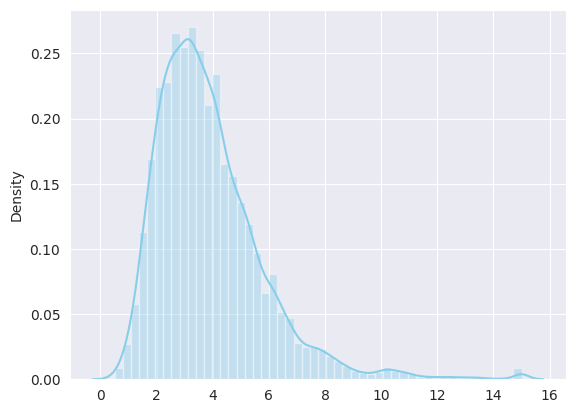

In [117]:
# Checking normal distribution of selected fetures
# median_income

sns.distplot(df_housing.select('median_income').toPandas(), color="skyblue")
df_housing.select(F.skewness('median_income'), F.kurtosis('median_income')).show()

# the median_income is normally distributed

In [118]:
featureCols = ["total_bedrooms", "population", "households", "median_income", "rooms_per_hosuehold", "poppulation_per_household"]

In [119]:
# Assembling features
feature_assembly = VectorAssembler(inputCols = featureCols, outputCol = 'features')
output = feature_assembly.transform(df_model)
output.show(3)

+-----+--------------+----------+----------+-------------+--------+--------+------------------+--------------------+
|price|total_bedrooms|population|households|median_income|rmsperhh|popperhh|   total_rooms_log|            features|
+-----+--------------+----------+----------+-------------+--------+--------+------------------+--------------------+
|4.526|         129.0|     322.0|     126.0|       8.3252|    6.98|    2.56| 2.110589710299249|[129.0,322.0,126....|
|3.585|        1106.0|    2401.0|    1138.0|       8.3014|    6.24|    2.11|3.0437551269686796|[1106.0,2401.0,11...|
|3.521|         190.0|     496.0|     177.0|       7.2574|    8.29|     2.8| 2.278753600952829|[190.0,496.0,177....|
+-----+--------------+----------+----------+-------------+--------+--------+------------------+--------------------+
only showing top 3 rows



In [120]:
# Normalizing the features
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output)

# Normalize each feature to have unit standard deviation.
scaledOutput = scalerModel.transform(output)
scaledOutput.show(3)

+-----+--------------+----------+----------+-------------+--------+--------+------------------+--------------------+--------------------+
|price|total_bedrooms|population|households|median_income|rmsperhh|popperhh|   total_rooms_log|            features|      scaledFeatures|
+-----+--------------+----------+----------+-------------+--------+--------+------------------+--------------------+--------------------+
|4.526|         129.0|     322.0|     126.0|       8.3252|    6.98|    2.56| 2.110589710299249|[129.0,322.0,126....|[0.30768013087921...|
|3.585|        1106.0|    2401.0|    1138.0|       8.3014|    6.24|    2.11|3.0437551269686796|[1106.0,2401.0,11...|[2.63793972676288...|
|3.521|         190.0|     496.0|     177.0|       7.2574|    8.29|     2.8| 2.278753600952829|[190.0,496.0,177....|[0.45317228579109...|
+-----+--------------+----------+----------+-------------+--------+--------+------------------+--------------------+--------------------+
only showing top 3 rows



In [121]:
# Selecting input and output column from output
df_model_final = scaledOutput.select(['price', 'scaledFeatures'])
df_model_final.show(3)

+-----+--------------------+
|price|      scaledFeatures|
+-----+--------------------+
|4.526|[0.30768013087921...|
|3.585|[2.63793972676288...|
|3.521|[0.45317228579109...|
+-----+--------------------+
only showing top 3 rows



In [122]:
# test train split
df_train, df_test = df_model_final.randomSplit([0.75, 0.25])
regressor = LinearRegression(featuresCol = 'scaledFeatures', labelCol = 'price')
regressor = regressor.fit(df_train)

In [123]:
# MSE for the train data
pred_results = regressor.evaluate(df_train)
print("The MAE for the model is: %2f"% pred_results.meanAbsoluteError)
print("The r2 for the model is: %2f"% pred_results.r2)

The MSE for the model is: 0.600611
The r2 for the model is: 0.512782


In [124]:
# Checking test performance
pred_results_test = regressor.evaluate(df_test)
print("The MAE for the model is: %2f"% pred_results_test.meanAbsoluteError)
print("The r2 for the model is: %2f"% pred_results_test.r2)

The MSE for the model is: 0.600611
The r2 for the model is: 0.512782


In [125]:
predictions = regressor.transform(df_test)

In [126]:
# Define the Random Forest Regressor
rf_regressor = RandomForestRegressor(featuresCol = 'scaledFeatures', labelCol = 'price')

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")


In [127]:
# Define the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf_regressor.numTrees, [10, 50, 100]) \
    .addGrid(rf_regressor.maxDepth, [5, 10, 20]) \
    .build()

# Define the cross-validator
crossval = CrossValidator(estimator=rf_regressor,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [128]:
# Fit the model
cvModel = crossval.fit(df_train)

In [130]:
# Make predictions and evaluate the model
predictions_train = cvModel.transform(df_train)
mae_train = evaluator.evaluate(predictions_train)
r2_train = evaluator_r2.evaluate(predictions_train)

print("The MAE for the model on train data is: %2f" % mae_train)
print("The r2 for the model is: %2f"% r2_train)

predictions_test = cvModel.transform(df_test)
mae_test = evaluator.evaluate(predictions_test)
r2_test = evaluator_r2.evaluate(predictions_test)

print("The MAE for the model on test data is: %2f" % mae_test)
print("The r2 for the model is: %2f"% r2_test)

The MAE for the model on train data is: 0.454169
The r2 for the model is: 0.721437
The MAE for the model on test data is: 0.513536
The r2 for the model is: 0.627601
